<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/ViT_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install einops

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from einops.layers.torch import Reduce
import ipdb
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

Files already downloaded and verified
torch.Size([100, 3, 32, 32]) torch.Size([100]) 10


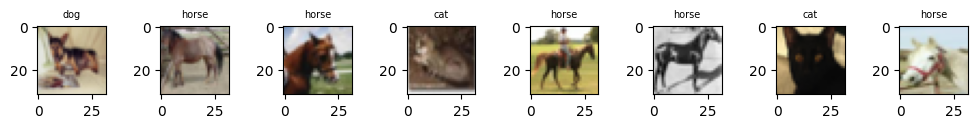

In [ ]:
trans = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root="dataset/", transform=trans, download=True, train=True) # 5W张图片 1,32,32
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(image.shape, label.shape, len(np.unique(label))) # 100,3,32,32; 100

trans_test = transforms.Compose([transforms.ToTensor()])
dataset_test = datasets.CIFAR10(root="dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
criterion_test = nn.CrossEntropyLoss()

fig, axs = plt.subplots(1, 8, figsize=(10, 1.25))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(rearrange(image[i], 'c h w -> h w c').cpu())
  ax.set_title(dataset.classes[label[i]], fontsize=7)
plt.tight_layout()
plt.show()

In [2]:
# https://www.jianshu.com/p/06a40338dc7c
class PatchEmbedding(nn.Module):
  def __init__(self, patch_size: int = 4, emb_size: int = 40, img_size: int = 32):
      self.patch_size = patch_size
      super().__init__()
      self.conv = nn.Conv2d(3, emb_size, kernel_size=patch_size, stride=patch_size)
      self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) # 1,1,40
      self.positions = nn.Parameter(torch.randn(((img_size) // patch_size) **2 + 1, emb_size)) # 65,40

  def forward(self, x):
      b, _, _, _ = x.shape # 100,1,32,32
      x = self.conv(x) # => 100,40,8,8
      x = rearrange(x, 'b e (h) (w) -> b (h w) e') # => 100,64,40
      cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) # => 100,1,40
      x = torch.cat([cls_tokens, x], dim=1) # => 100,65,40
      x += self.positions
      return x # 100,65,40

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size: int = 40, num_heads: int = 4, dropout: float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.qkv = nn.Linear(emb_size, emb_size * 3)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x):
    x = self.qkv(x) # 100,65,40 => 100,65,120
    qkv = rearrange(x, "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3) # => 3,100,4,65,10
    queries, keys, values = qkv[0], qkv[1], qkv[2] # => 100,4,65,10
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # => 100,4,65,65
    scaling = self.emb_size ** (1/2)
    att = nn.functional.softmax(energy, dim=-1) / scaling
    att = self.att_drop(att)

    out = torch.einsum('bhal, bhlv -> bhav ', att, values) # => 100,4,65,10
    out = rearrange(out, "b h n d -> b n (h d)") # => 100,65,40
    out = self.projection(out) # => 100,65,40
    return out

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x):
    res = x
    x = self.fn(x)
    x += res
    return x

class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
    super().__init__(
      nn.Linear(emb_size, expansion * emb_size),
      nn.GELU(),
      nn.Dropout(drop_p),
      nn.Linear(expansion * emb_size, emb_size),
    )

class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,emb_size: int = 40,drop_p: float = 0.):
    super().__init__(
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        MultiHeadAttention(),
        nn.Dropout(drop_p)
      )),
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        FeedForwardBlock(emb_size),
        nn.Dropout(drop_p)
      )
      ))

class TransformerEncoder(nn.Sequential):
  def __init__(self, depth: int = 12):
    super().__init__(*[TransformerEncoderBlock() for _ in range(depth)])

class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size: int = 40, n_classes: int = 10):
    super().__init__(
      Reduce('b n e -> b e', reduction='mean'), # 100,65,40 => 100,40
      nn.LayerNorm(emb_size),
      nn.Linear(emb_size, n_classes)) # 100,40 => 100,10

class ViT(nn.Sequential):
  def __init__(self):
    super().__init__(
      PatchEmbedding(),
      TransformerEncoder(),
      ClassificationHead()
    )

model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 40, 8, 8]           1,960
    PatchEmbedding-2               [-1, 65, 40]               0
         LayerNorm-3               [-1, 65, 40]              80
            Linear-4              [-1, 65, 120]           4,920
           Dropout-5            [-1, 4, 65, 65]               0
            Linear-6               [-1, 65, 40]           1,640
MultiHeadAttention-7               [-1, 65, 40]               0
           Dropout-8               [-1, 65, 40]               0
       ResidualAdd-9               [-1, 65, 40]               0
        LayerNorm-10               [-1, 65, 40]              80
           Linear-11              [-1, 65, 160]           6,560
             GELU-12              [-1, 65, 160]               0
          Dropout-13              [-1, 65, 160]               0
           Linear-14               [-1,

In [ ]:
for epoch in range(1,4):
  total_loss = []
  errorTotal = 0
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())
    maxV,maxIdx = outputs.max(dim=1)
    errorNum = torch.sum(torch.ne(maxIdx, label)).item()
    errorTotal += errorNum

    if(batch_idx % 100 == 99):
      print("epoch:{} batch:{} loss:{:.2f} mean:{:.2f} error:{}/100 errorTotal:{}/{} {:.2f}%".format(
          epoch, batch_idx, loss, np.mean(total_loss), errorNum, errorTotal, (batch_idx+1) * 100, errorTotal / (batch_idx+1)))

epoch:1 batch:99 loss:2.18 mean:2.28 error:80/100 errorTotal:8528/10000 85.28%
epoch:1 batch:199 loss:2.11 mean:2.23 error:80/100 errorTotal:16637/20000 83.19%
epoch:1 batch:299 loss:1.99 mean:2.18 error:73/100 errorTotal:24432/30000 81.44%
epoch:1 batch:399 loss:2.08 mean:2.15 error:76/100 errorTotal:32032/40000 80.08%
epoch:1 batch:499 loss:1.98 mean:2.12 error:72/100 errorTotal:39497/50000 78.99%
epoch:2 batch:99 loss:2.10 mean:2.00 error:79/100 errorTotal:7336/10000 73.36%
epoch:2 batch:199 loss:1.94 mean:1.98 error:63/100 errorTotal:14530/20000 72.65%
epoch:2 batch:299 loss:2.07 mean:1.97 error:75/100 errorTotal:21618/30000 72.06%
epoch:2 batch:399 loss:1.95 mean:1.96 error:72/100 errorTotal:28688/40000 71.72%
epoch:2 batch:499 loss:1.91 mean:1.95 error:64/100 errorTotal:35634/50000 71.27%
epoch:3 batch:99 loss:1.88 mean:1.87 error:69/100 errorTotal:6787/10000 67.87%
epoch:3 batch:199 loss:1.81 mean:1.87 error:65/100 errorTotal:13569/20000 67.84%
epoch:3 batch:299 loss:2.04 mean:1

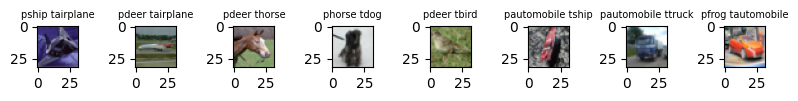

batch:9 loss:1.88 mean:1.80 error:8/100 errorTotal:633/1000 63.30%


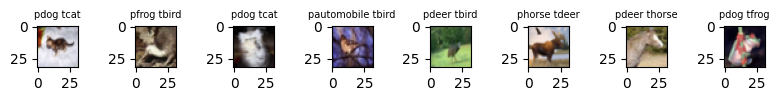

batch:19 loss:1.71 mean:1.78 error:8/100 errorTotal:1259/2000 62.95%


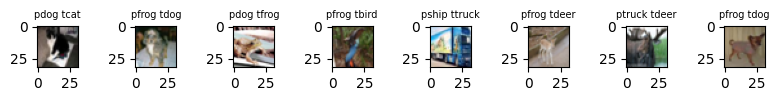

batch:29 loss:1.79 mean:1.79 error:8/100 errorTotal:1903/3000 63.43%


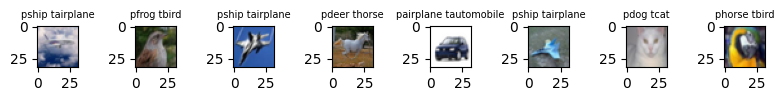

batch:39 loss:1.74 mean:1.79 error:8/100 errorTotal:2559/4000 63.98%


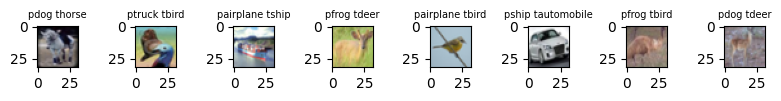

batch:49 loss:1.75 mean:1.79 error:8/100 errorTotal:3195/5000 63.90%


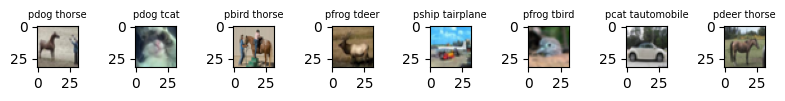

batch:59 loss:1.61 mean:1.78 error:8/100 errorTotal:3822/6000 63.70%


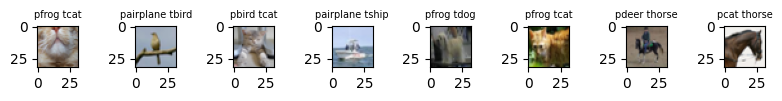

batch:69 loss:1.88 mean:1.79 error:8/100 errorTotal:4471/7000 63.87%


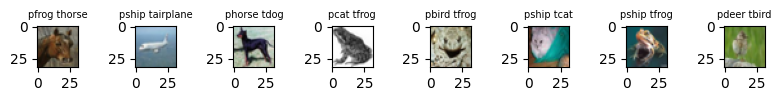

batch:79 loss:1.71 mean:1.79 error:8/100 errorTotal:5128/8000 64.10%


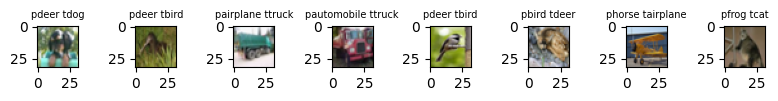

batch:89 loss:1.84 mean:1.80 error:8/100 errorTotal:5758/9000 63.98%


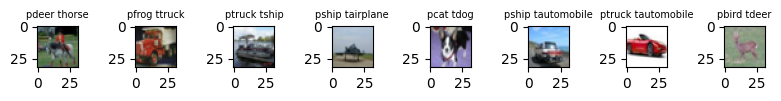

batch:99 loss:1.81 mean:1.79 error:8/100 errorTotal:6375/10000 63.75%


In [ ]:
total_loss = []
errorTotal = 0
for batch_idx, (img, label) in enumerate(loader_test): # 1W张图片, 100批, 100,3,32,32
  img = img.to(device)
  label = label.to(device)

  output = model(img)
  loss = criterion_test(output, label)
  total_loss.append(loss.item())

  maxV,maxIdx = output.max(dim=1)
  errorNum = torch.sum(torch.ne(maxIdx, label)).item()
  errorTotal += errorNum

  noMatchIdx = torch.nonzero(torch.ne(maxIdx, label)).view(-1)

  if(batch_idx % 10 == 9):
    if errorNum > 8:
      errorNum = 8
    fig, axs = plt.subplots(1, errorNum, figsize=(errorNum, 1))
    if not isinstance(axs, np.ndarray):
      axs = [axs]
    for i, ax in enumerate(axs.flatten()):
      idx = noMatchIdx[i]
      ax.imshow(rearrange(img[idx], 'c h w -> h w c').cpu())
      ax.set_title('p{} t{}'.format(dataset.classes[maxIdx[idx]], dataset.classes[label[idx]]), fontsize=7)
    plt.tight_layout()
    plt.show()
    print("batch:{} loss:{:.2f} mean:{:.2f} error:{}/100 errorTotal:{}/{} {:.2f}%".format(
        batch_idx, loss, np.mean(total_loss), errorNum, errorTotal, (batch_idx+1) * 100, errorTotal / (batch_idx+1)))